In [81]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import torchvision
import torch
import time

from torch import nn 
from torch import optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset, Dataset

import torchvision.transforms as transforms
import torchvision.transforms as tt

from tqdm.notebook import tqdm

from facenet_pytorch import MTCNN

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score


# Обработка данных.


Я выбрал датасет https://www.kaggle.com/datamunge/sign-language-mnist, так как на первый взгляд он показался максимально адекватным для наших задачи.

In [82]:
train_file_path = 'sign_mnist/sign_mnist_train/sign_mnist_train.csv'
test_file_path = 'sign_mnist/sign_mnist_test/sign_mnist_test.csv'

Загружаем данные и смотрим что внутри.

In [83]:
data = pd.read_csv(train_file_path).to_numpy()

Отрисуем какую-нибудь картинку

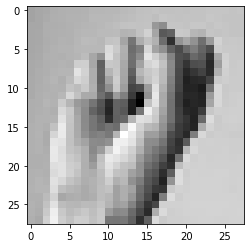

In [84]:
image_num = 27
label = data[image_num][0]
image = data[image_num][1:].reshape((28,28))
plt.imshow(image,cmap = 'gray')

У нас набор фотографий (28,28) серого цвета. 23 класса знаков которые они репрезентуют. Отсутствуют J и Z, так как для этих знаков нужно движение рукой. Создадим калсс для обработки наших данных.

In [85]:
class CreateDataset:
    """ 
    Class for preparing data for neural network.
    While creating train dataset, adapts for creating train dataset.
    """
    def __init__(self):
        self.flag = 0
        self.number_of_classes = 0
        letters = list('abcdefghijklmnopqrstuvwxyz')
        self.right_letters = list('abcdefghiklmnopqrstuvwxy')
        self.right_letters.reverse()
        self.indx_letters = dict(zip(range(0,25), letters))
        self.letters_indx = dict(zip(letters, range(0,25)))
        self.our_sighs = None
        self.num_of_classes = None
        self.our_idnxs = None
        self.new_indexes = None
        self.transforms = tt.Compose([
            tt.RandomPerspective(distortion_scale=0.15, p=0.5),
            tt.RandomHorizontalFlip(),
            tt.RandomRotation(30),    
            tt.Normalize((0.5), (0.5), inplace=True)
        ])
    
    
    def create_data_from_path(self, file_path:str):
        '''
        Take file path and create 2 lists, one with images, second with labels.

        input: 
            file path in string type

        output:
            images : normilized np.array of images in shape(num_of_images, 28, 28)
            labels : list of labels
        '''

        data = pd.read_csv(file_path).to_numpy()
        labels = []
        images = []
        for img in data:
            labels.append(img[0])
            images.append(img[1:].reshape((28,28)))
        return np.array(images)/255, labels


    def class_filter(self, given_images, given_labels, latters_to_stay, make_wrong_class=False):
        """ 
        Filter our images and labels, with given list of sighns to stay in data.
        If make_wrong_class is True creates one more class with random choice of
        images from skipped classes, and gives them one class. If False numbers_of_classes
        equal quantity of our sighns.

        input:
            given_images: np.array of images in shape (channels, 28,28)
            given_labels: list of labels in shape (channels)
            latters_to_stay: list of our sighns
            make_wrong_class: boolean, if True create new class with mash of ower sighns.

        output:
            images : np.array of coisen images of signs from dataset of shape (channels, 28, 28)
            labels: np.array of choisen labels (if make_wrong_class is true create one more class)
        """

        self.our_sighs = latters_to_stay
        self.num_of_classes = len(self.our_sighs)
        self.our_idnxs = [self.letters_indx[i] for i in self.our_sighs]
        self.new_indexes = dict(zip(range(0,7), latters_to_stay))

        indxs_to_stay = [self.letters_indx[i] for i in latters_to_stay]
        our_labels = [i for i in range(len(given_labels)) if given_labels[i] in indxs_to_stay]
        labels = np.take(given_labels, our_labels)
        labels = np.array([self.our_idnxs.index(i) for i in labels])
        images = np.take(given_images, our_labels, axis=0)
        
        if make_wrong_class:
            temp = indxs_to_stay.copy()
            temp.append(9)
            wrong_indxes = set(list(range(24))) - set(temp)
            not_our_labels = [i for i in range(len(given_labels)) if given_labels[i] in wrong_indxes]
            wrong_labels = np.take(given_labels, not_our_labels)
            wrong_images = np.take(given_images, not_our_labels, axis=0)
            one_sign_quantity = int(len(given_labels) / (14 - len(indxs_to_stay)))
            wrong_images =  wrong_images[:one_sign_quantity]
            wrong_labels = (np.ones(one_sign_quantity) * len(indxs_to_stay)).astype('int32')
            images = np.concatenate((images, wrong_images), 0)
            labels = np.concatenate((labels, wrong_labels), 0)
            if self.flag == 0:
                self.num_of_classes += 1
                self.new_indexes[self.num_of_classes - 1] = 'something different'
            
            with open('our_sighs.txt', 'w') as file:
                file.write(str(self.new_indexes))
        return images, labels 

    class CustomLoader(Dataset):
        """
        Makes custom loader from given images and labels, uses tranform if given/
        """
        def __init__(self, images, labels, transform=None, target_transform=None):
            self.img_labels = labels
            self.images = images
            self.transform = transform
            self.target_transform = target_transform

        def __len__(self):
            return len(self.img_labels)

        def __getitem__(self, idx):
            image = torch.FloatTensor(self.images[idx]).reshape((1,28,28))
            label = self.img_labels[idx]

            if self.transform:
                image = self.transform(image)
            return image, torch.tensor(label, dtype=torch.long)

    def make_dataset(self, images, lables, batch=16, shuffle=True, transform=False):
        """
        Creates dataloader wich allowed for our neural network. 

        input:
            images: np.array of images (chanels, 28,28)
        """
        # images =  images.reshape(images.shape[0], 28,28)
        # data = TensorDataset(torch.FloatTensor(images), torch.tensor(lables, dtype=torch.long).float())
        if transform == True:
            transform = self.transforms
        data = CreateDataset.CustomLoader(images, lables, transform=transform)
        data_loader = DataLoader(data, batch_size=batch, shuffle=shuffle)
        return data_loader

In [86]:
dataset = CreateDataset()

In [87]:
train_images, train_labels = dataset.create_data_from_path(train_file_path)

Посмотрим на знаки которые есть в нашем датасете.

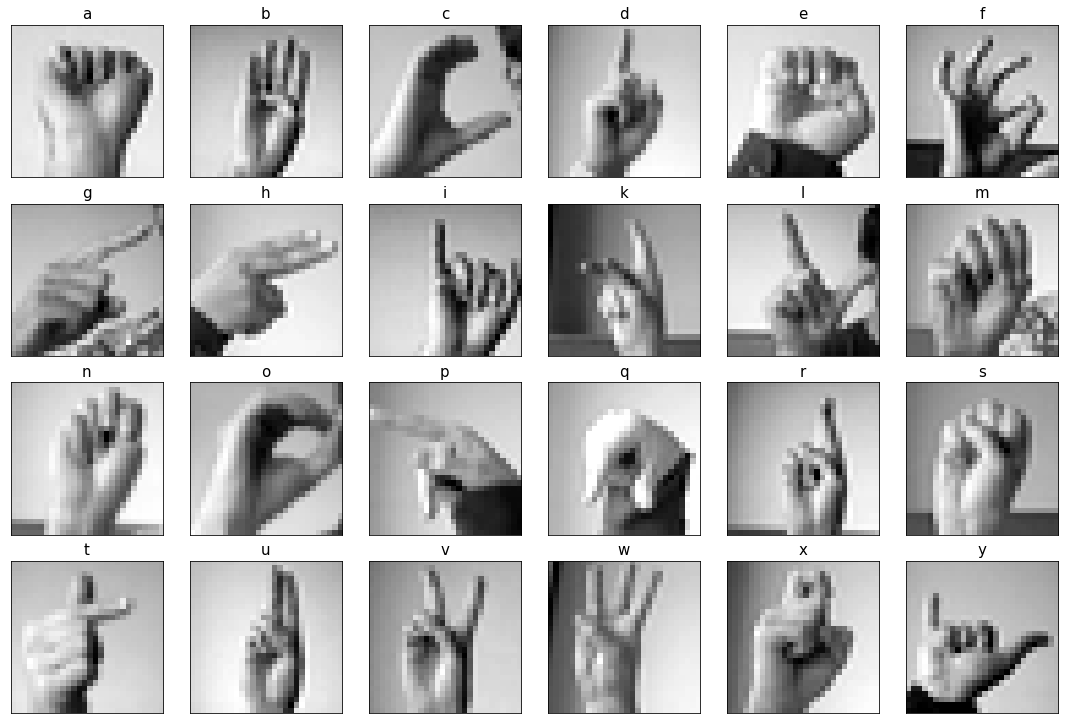

In [88]:
fig, axes = plt.subplots(nrows=4, ncols=6, figsize=(15, 10),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
        letter = dataset.right_letters.pop()
        idx = dataset.letters_indx[letter]      
        ax.imshow(train_images[train_labels.index(idx)], cmap = 'gray')
        ax.set_title(letter, fontsize = 15)
plt.tight_layout(pad=0.5)
plt.show()

In [89]:
train_images.shape, len(train_labels)

((27455, 28, 28), 27455)

Все знаки нам не нужны, оставним несколько знаков.

In [90]:
our_sighs = list('wuavfo')

In [91]:
wrong_class = True

In [92]:
train_images, train_labels = dataset.class_filter(
    train_images, 
    train_labels, 
    our_sighs, 
    make_wrong_class=wrong_class
)

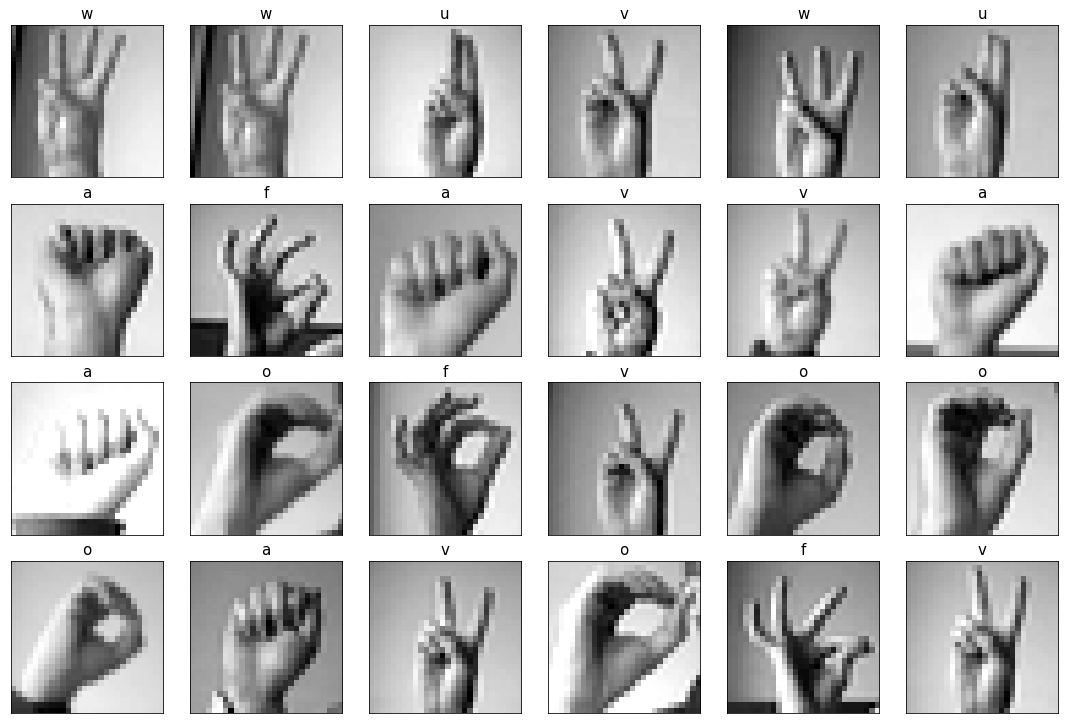

In [93]:
fig, axes = plt.subplots(nrows=4, ncols=6, figsize=(15, 10),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):      
        ax.imshow(train_images[i], cmap = 'gray')
        ax.set_title(dataset.new_indexes[train_labels[i]], fontsize = 15)
plt.tight_layout(pad=0.5)
plt.show()

 Чистка прошла хороша, так же мы создали один дополнительный класс куда поместили мусор от ненужных классов.

In [94]:
dataset.num_of_classes

7

# Нейронная сеть

In [95]:
batch = 16
shuffle = True

In [96]:
train_loader = dataset.make_dataset(train_images, train_labels, batch=batch, transform=True)

In [97]:
PATH = './hand_recognition.pth'

Выбрал модель на основе AlexNet, так как она не очень тяжелая, и хорошо справляется с картинками такого размера. Так же я добавил в нее BatchNorm, что бы она быстрее сходилась. Dropout что бы не переобучалас. Так же поставил softmax в конце что бы получать вероятности классов, что бы выбирать только те картинки в которых сеть уверена с большой вероятностью.

In [98]:
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1_1 = nn.Conv2d(1, 100, 5, padding=2)
        self.bn1_1 = nn.BatchNorm2d(100)
        self.conv1_2 = nn.Conv2d(100, 200, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.bn1_2 = nn.BatchNorm2d(200)
        self.conv2_1 = nn.Conv2d(200, 300, 5, padding=2)
        self.bn2_1 = nn.BatchNorm2d(300)
        self.conv2_2 = nn.Conv2d(300, 300, 3, padding=1)
        self.bn2_2 = nn.BatchNorm2d(300)
        self.fc1 = nn.Linear(300 * 7 * 7, 300)
        self.dr = torch.nn.Dropout2d(0.5)
        self.fc2 = nn.Linear(300, 300)
        self.fc3 = nn.Linear(300, dataset.num_of_classes)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = F.relu(self.conv1_1(x))
        x = self.bn1_1(x)
        x = F.relu(self.conv1_2(x))
        x = self.bn1_2(x)
        x = self.pool(x)
        x = F.relu(self.conv2_1(x))
        x = self.bn2_1(x)
        x = F.relu(self.conv2_2(x))
        x = self.bn2_2(x)
        x = self.pool(x)
        x = x.view(-1, 300 * 7 * 7)

        x = F.relu(self.fc1(x))
        x = self.dr(x)

        x = F.relu(self.fc2(x))
        x = self.dr(x)
        x = self.fc3(x)
        x = self.softmax(x)
        return x

За очень большое число экспериментов, подобрал к сети параметры, пока не придумал как это лучше делать в данном случае, так как оказалось, что точность сети совсем не отвечает нашим потребностям. Сеть может идеально научиться различать выбранные нами знаки, но при этом будет фотографию ботинка классифицировать как один из них (для этого и был создан дополнительный класс с остатками от датасета, что бы уменьшить этот эффект).

In [99]:
epochs = 30
verbose = True

In [100]:

net = Net().to('cuda')

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.00002)

for epoch in tqdm(range(epochs)):
    print(f'New №{epoch} epoch started!')
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data[0], data[1]

        # обнуляем градиент
        optimizer.zero_grad()
        # print(inputs.type())
        outputs = net(inputs.cuda())
        loss = criterion(outputs, labels.cuda())
        loss.backward()
        optimizer.step()
        # выводим статистику о процессе обучения
        running_loss += loss.item()
        if verbose:
            if i % 300 == 0 and i != 0:    # печатаем каждые 300 mini-batches
                print('[%d, %5d] loss: %.9f' %
                    (epoch + 1, i + 1, running_loss / 2000))
                running_loss = 0.0

print('Training is finished!')

#### Сохранение модели


torch.save(net.state_dict(), PATH)

print("Model state_dict: ")
for param in net.state_dict():
    print(param," \ ", net.state_dict()[param].size())

  0%|          | 0/30 [00:00<?, ?it/s]

New №0 epoch started!
[1,   301] loss: 0.276592597
[1,   601] loss: 0.263197340
New №1 epoch started!
[2,   301] loss: 0.243348062
[2,   601] loss: 0.229437988
New №2 epoch started!
[3,   301] loss: 0.223131113
[3,   601] loss: 0.218113639
New №3 epoch started!
[4,   301] loss: 0.210854206
[4,   601] loss: 0.206210065
New №4 epoch started!
[5,   301] loss: 0.203897240
[5,   601] loss: 0.200429999
New №5 epoch started!
[6,   301] loss: 0.199319840
[6,   601] loss: 0.198249057
New №6 epoch started!
[7,   301] loss: 0.197451930
[7,   601] loss: 0.196015583
New №7 epoch started!
[8,   301] loss: 0.197300429
[8,   601] loss: 0.195089942
New №8 epoch started!
[9,   301] loss: 0.194820805
[9,   601] loss: 0.195439814
New №9 epoch started!
[10,   301] loss: 0.195954199
[10,   601] loss: 0.192997260
New №10 epoch started!
[11,   301] loss: 0.194366805
[11,   601] loss: 0.194468961
New №11 epoch started!
[12,   301] loss: 0.194050561
[12,   601] loss: 0.187544872
New №12 epoch started!
[13,   30

Выгрузим модель из файла, для того что бы в следующие разы можно было скипнуть обучение модели. Так как многое последующее использует обьект dataset, все предыдущие вычисления нужны для запуска модели.
Я думал о переносе конкретно приложения в другой файл, но для этого нужно было бы сохранить модель, наши выбранные символы, все созданные классы, атак же нашим классом обработать снова тренеровочные данные. Что мне показалось не целесообразным. Я решил продолжить в этом файле.

In [101]:
net = Net()
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [102]:
def net_output(loader):
    """
    Return net output from given loader

    input:
        laoder: DataLoader object

    output:
        true_labels: list of true labels
        out: list ofpredicted labels by our neural newtwork
    """
    out =[]
    true_lables = []
    for batch_images, batch_labels in loader:
        _, predicted_lables = torch.max(net(batch_images), 1)
        out.extend(predicted_lables.detach().cpu().numpy())
        true_lables.extend(batch_labels.detach().cpu().numpy())
    return true_lables, out

In [103]:
true_lables, out = net_output(train_loader)
accuracy_score(true_lables, out)

0.9929016786570743

Точность на тренеровочном датасете 99%.

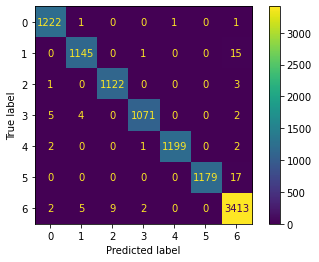

In [104]:

matrix = confusion_matrix(true_lables, out)
disp = ConfusionMatrixDisplay(matrix)
disp.plot() 

In [105]:
test_images, test_labels = dataset.create_data_from_path(test_file_path)
test_images, test_labels = dataset.class_filter(
    test_images, 
    test_labels, 
    our_sighs,
    make_wrong_class=wrong_class
)
test_loader = dataset.make_dataset(test_images, test_labels, batch=200, shuffle=False)

In [106]:
true_lables, out = net_output(test_loader)
accuracy_score(true_lables, out)

0.9676910953506698

ТОчность на трейне 96%.

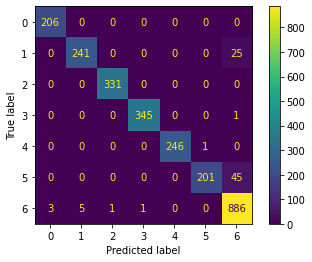

In [107]:

matrix = confusion_matrix(true_lables, out)
disp = ConfusionMatrixDisplay(matrix)
disp.plot() 

На тесте мы получили 96% точности, можно получить и больше ~98%. Но конкретно эта сеть делает не так много ошибок, и у нее нету ложного срабатывания на мой задний фон. Вообще как мне кажется основная сложность данного проэкта была именно в датасете. Я выбрал средний вариант (не много обработки). Но к сожалению датасет оказался слишком однообразный. Можно построить простую сеть которая хорошо научится опозновать тестовый датасет, с вероятностью 99.9%. Но к сожалению из за однобразности картинок очень плохо получается распозновать что-то другое кроме картинок в этом датасете.

Для того что бы сеть не срабатывала каждый раз, я сделал отдельный класс, в который напихал оставшихся не взятых нами знаков, что бы если сеть не распознает знак, она сваливалась в них. В результате обдумав все сделанное, мне кажется, что более эффективно было бы потратить время на создание собственного датасета. Тем более это не очень сложно. Но сейчас уже нету на это времени. Хотя в данной ситуации борьба с конкретным датасетом дала понимание многих процессов.

# Приложение

В данной ситуации не совсем понимаю как сделать класс для приложения, так как в процессе его использования мне нужно слишком много всего из предобработки. например названия символов которые мы выбрали. Так же нужен обьект dataset в котором хранится много всего полезного для нашей модели. Если я тут сделаю класс то он будет слишком завязан на внутреннем состоянии другого класса, что является плохой практикой как я понимаю.

In [108]:
cap = cv2.VideoCapture(0)
mtcnn = MTCNN()

In [109]:
font = cv2.FONT_HERSHEY_SIMPLEX
fontScale = 0.8
fontColor = (125,125,0)
lineType = 2
cut_box = [0.6875, 0.2583, 1, 0.75]

In [110]:
def make_box_by_img_size(shape):
    """
    Create coordinates of box where to put your sign, depends on camera 
    resolution. Creates coordinates for text above this box.

    input:
        shape: shape of image

     return:
        two tuples of coordinates first for box second for text.  
    """
    h = shape[0]
    w = shape[1]
    x1 = int(cut_box[0] * w)
    y1 = int(cut_box[1] * h)
    x2 = int(cut_box[2] * w)
    y2 = int(cut_box[3] * h)
    x_text = int(0.7 * w)
    y_text = int(0.20 * h)
    return ((x1, y1), (x2, y2)), (x_text, y_text)

In [111]:
def draw_triangle(image):
    """
    Draw trinagle for sign placement and text on it, used only if face appear.

    input:
        image: image from webcam

    output:
        image: revorked image
    """
    box, text_box = make_box_by_img_size(image.shape)
    cv2.rectangle(
        image,
        box[0],
        box[1],
        (fontColor),
        thickness=2
    )
    cv2.putText(image,'Place for sign!', 
    text_box, 
    font, 
    fontScale,
    fontColor,
    lineType)
    
    cv2.putText(image,'I found you! Show some sign into the box.', 
    (int(image.shape[1]* 0.1), int(image.shape[0] * 0.95)), 
    font, 
    fontScale,
    fontColor,
    lineType)
    return image

In [116]:
def cut_sign(img_for_cut):
    """
    Cut image of sigh from big webcam picture.

    input:
        img_for_cut: numpy.array image

    output:
        cut_iamge: numpy.array  cut image
    """
    shape = img_for_cut.shape
    cut_image = img_for_cut[
        int(cut_box[1] * shape[0]): int(cut_box[3] * shape[0]),
        int(cut_box[0] * shape[1]): int(cut_box[2] * shape[1])]
    return cut_image

In [113]:
def draw_sign(predict, image, index):
    """
    Draw captured sign, and predicted label of this sign.  
    """
    fig, ax = plt.subplots()
    ax.imshow(image)
    ax.set_title(index[int(torch.max(predict, 1)[1])])
    plt.show()

In [114]:
"""  
check sign box and cut it, and check can we recognize this sign.
if yes then make on of the following acton
v - greeting this person
a - make screenshot and save it
f - show some picture of punk for 3 seconds.
my imagination run out here
"""

def run():
    # create time point for preventing multitriggering 
    previous_activation_time = time.time()
    while True:
        # capture video frame
        _, frame = cap.read() #(480,640)
        #ask mtcnn about probability of face on that frame
        _, probs = mtcnn.detect(frame)
        # make gorizontal flip of frame for better usability
        frame = cv2.flip(frame, 1)
        #if nobody on frame, just show frame
        if probs is None:
            cv2.imshow('Hand detection', frame)
            key = cv2.waitKey(1)
            if key & 0xFF == ord('q'):
                    break

        # if some person found: Greet him and show the interface
        else:
            revorked_frame = draw_triangle(frame.copy())
            cv2.imshow('Hand detection', revorked_frame)
            
            key = cv2.waitKey(1)
            if key & 0xFF == ord('q'):
                    break

            gray_image = cv2.cvtColor(revorked_frame, cv2.COLOR_BGR2GRAY)
            cut_image = cut_sign(gray_image)
            some_image = cv2.resize(cv2.flip(cut_image,1), (28,28))
            some_image_loader = dataset.make_dataset(some_image.reshape(1,28,28)/255, [1], batch=1)
            predict = net(iter(some_image_loader).next()[0])
            max_value = np.max(predict.detach().numpy())
            if max_value > 0.98 and max_value != predict[-1][-1] and time.time() - previous_activation_time > 1:
                previous_activation_time = time.time()
                draw_sign(predict, some_image, dataset.new_indexes)
                sign = dataset.new_indexes[int(torch.max(predict, 1)[1])]

                if sign == 'v':
                    print("Hello my friend!!!")

                if sign == 'a':
                    cv2.imwrite('screenshot.jpg', frame)
                    print('Screanshot saved!')

                if sign == 'f':
                    punk_image = cv2.imread(f'punks/{np.random.randint(5)}.jpg')
                    cv2.imshow('Hand detection', punk_image)
                    key = cv2.waitKey(1)
                    if key & 0xFF == ord('q'):
                        break
                    time.sleep(3)
                    
                
    cap.release()
    cv2.destroyAllWindows()

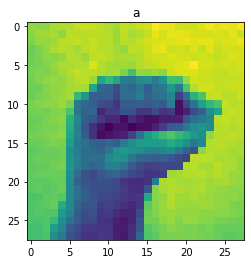

Screanshot saved!


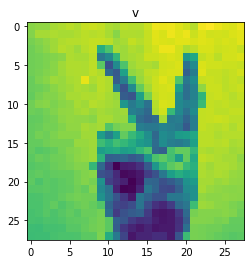

Hello my friend!!!


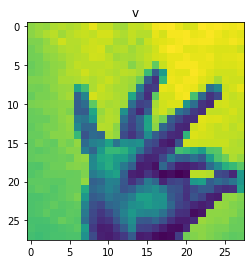

Hello my friend!!!


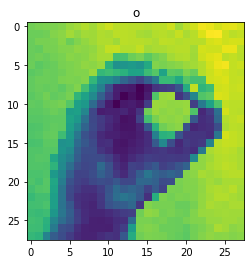

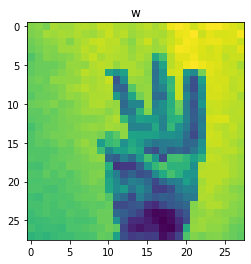

In [115]:
image = 0
run()

Это пример использвания. Как видно есть ложные срабатывания, но конкретно у этой сетки нету проблем с моим фоном. У других вариантов иногда он срабатывал как какаято буква. Причем от обучения к обучению, как мне кажется очень сильно зависит Какие именно занки будут плохо узнаваться. Например буква f почти всегда узнавалась лучше всех и многие знаки ложно сроабатывали в ее сторону. В данной же сетке у меня не получилось ее вызвать. 